# exploring ucb & bayesian bandits
### building on the non-stationary k-armed bandit problem framework

In [1]:
%matplotlib inline

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
class KBanditProblem:
    
    def __init__(self, k=10, stationary=True):
        self.k = k
        self.stationary = stationary
        self.values = np.random.normal(loc=0.0, scale=1, size=k)
        self.optimal = self.values.argmax()
        
    def generate_reward(self, action):
        if not self.stationary:
            self.values += np.random.normal(loc=0.0, scale=0.01, size=self.k)
            self.optimal = self.values.argmax()
            
        return np.random.normal(loc=self.values[action], scale=1)

In [3]:
class KBanditSolution:
    
    def __init__(self, problem, steps):
        self.problem = problem
        self.steps = steps
        
        self.average_reward = 0
        self.average_rewards = np.array([])
        self.optimal_percentage = 0
        self.optimal_percentages = np.array([])
        
    def count_statistics(self, action, reward, step):
        self.average_reward += (reward - self.average_reward) / (step + 1)
        self.average_rewards = np.append(self.average_rewards, self.average_reward)
        
        self.optimal_percentage += ((1 if action == self.problem.optimal else 0) - self.optimal_percentage) / (step + 1)
        self.optimal_percentages = np.append(self.optimal_percentages, self.optimal_percentage)

### validate e-greedy static solution

In [4]:
class EGreedy(KBanditSolution):
    
    # same solver algo previously discussed
    def solve(self, exploration_rate, initial_value=0):
        Q = {i: initial_value for i in range(self.problem.k)} # value func
        N = {i: 0 for i in range(self.problem.k)} # action counter
        
        for i in range(self.steps):
            if (random.uniform(0,1) < exploration_rate):
                action = random.randint(0, self.problem.k-1)
            else:
                action = max(Q, key=Q.get)
        
            reward = self.problem.generate_reward(action)
            N[action] += 1
            Q[action] += (reward - Q[action]) / N[action]
            self.count_statistics(action, reward, i)

In [5]:
# simulate against different exploit rates

prob = KBanditProblem()
steps = 500
simulations = 500
rates = [0, .1, .2]
df = pd.DataFrame(columns=['simulation', 'rate','step','reward_avg','optimal_pct'])

for i in range(simulations):
    for rate in rates:
        egreedy = EGreedy(prob, steps)
        egreedy.solve(rate)

        d = {'simulation':i,
             'rate':rate,
             'step':list(range(1, steps+1)),
             'reward_avg': egreedy.average_rewards,
             'optimal_pct': egreedy.optimal_percentages}
        temp_df = pd.DataFrame(data=d)

        df = pd.concat([df, temp_df])


print(len(df))
df.head()

750000


,optimal_pct,rate,reward_avg,simulation,step
0,0.0,0,0.656297,0,1
1,0.0,0,1.549492,0,2
2,0.0,0,1.851933,0,3
3,0.0,0,1.867891,0,4
4,0.0,0,1.536822,0,5


In [6]:
plot_df = df.groupby(['rate','step']).mean()
plot_df.head()

optimal_pct  reward_avg
rate step                         
0.0  1             0.0    1.540400
     2             0.0    1.437636
     3             0.0    1.430849
     4             0.0    1.426460
     5             0.0    1.444396

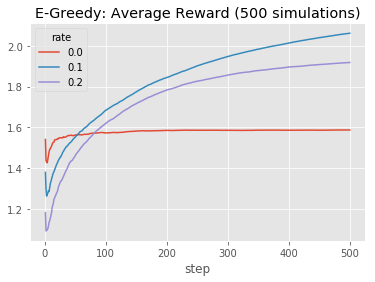

In [7]:
plot_df['reward_avg'].unstack(level=0).plot(title = 'E-Greedy: Average Reward ({} simulations)'.format(simulations))

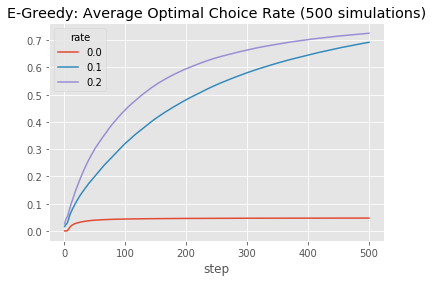

In [10]:
plot_df['optimal_pct'].unstack(level=0).plot(title = 'E-Greedy: Average Optimal Choice Rate ({} simulations)'.format(simulations))

### eval initial weights

In [14]:
# simulate against different initial values

prob = KBanditProblem()
steps = 500
simulations = 500
rate = .2

init_vals = [0, 1] 

df = pd.DataFrame(columns=['simulation', 'init_value','step','reward_avg','optimal_pct'])

for i in range(simulations):
    for init_val in init_vals:
        egreedy = EGreedy(prob, steps)
        egreedy.solve(rate, init_val)

        d = {'simulation':i,
             'init_value': init_val,
             'step':list(range(1, steps+1)),
             'reward_avg': egreedy.average_rewards,
             'optimal_pct': egreedy.optimal_percentages}
        temp_df = pd.DataFrame(data=d)

        df = pd.concat([df, temp_df])


print(len(df))
df.head()

500000


,init_value,optimal_pct,reward_avg,simulation,step
0,0,0.0,0.486466,0,1
1,0,0.0,0.058360,0,2
2,0,0.0,-0.009947,0,3
3,0,0.0,0.161583,0,4
4,0,0.0,-0.284136,0,5


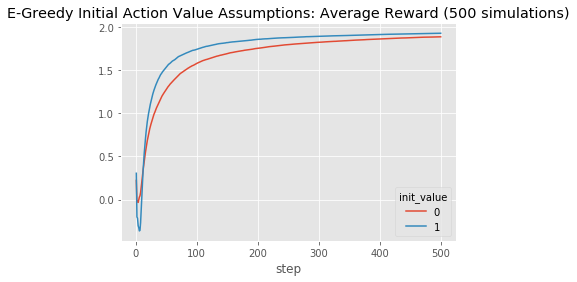

In [15]:
plot_df = df.groupby(['init_value','step']).mean()
plot_df['reward_avg'].unstack(level=0).plot(title = 'E-Greedy Initial Action Value Assumptions: Average Reward ({} simulations)'.format(simulations))

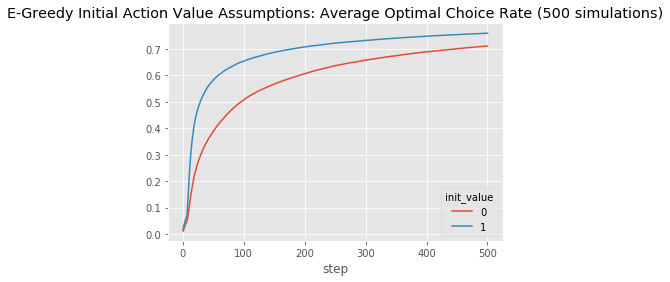

In [16]:
plot_df['optimal_pct'].unstack(level=0).plot(title = 'E-Greedy Initial Action Value Assumptions: Average Optimal Choice Rate ({} simulations)'.format(simulations))

# Upper-Confidence-Bound (UCB)